# statistical comparisons

Notebook to run post-hoc pairwise statistical comparisons between methods on the ground-truth and black-box regression problems.

In [1]:
from scipy.stats import wilcoxon 
import pandas as pd
import itertools as it
import os
import seaborn as sns
sns.set(font_scale=1.5, style='white')

figdir = 'figs/stats/'
rdir = '../results/'

print('figdir:',figdir)
def save(h=None,name='tmp'):
    name = name.strip().replace(' ','-').replace('%','pct')
    if h == None:
        h = plt.gcf()
    h.tight_layout()
    print('saving',figdir+'/'+name+'.png')
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    plt.savefig(figdir+'/'+name+'.png', bbox_inches='tight')

figdir: figs/stats/


In [2]:
import pdb
import numpy as np

def pairwise_pval(df, metric, alg1, alg2):
    df = df.loc[df.algorithm.isin([alg1, alg2]),:].copy()
    x = df.loc[df.algorithm==alg1, metric].values 
    y = df.loc[df.algorithm==alg2, metric].values 
    eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
    if metric.endswith('norm'):
        rmetric = metric.replace('norm','rank')
    else:
        rmetric = metric+'_rank'
    if rmetric not in df.columns:
        rmetric = metric
        
    x_rank = df.loc[df.algorithm==alg1, rmetric].values 
    y_rank = df.loc[df.algorithm==alg2, rmetric].values 
#     pdb.set_trace()
    if len(x) != len(y):
        print(alg1, len(x))
        print(alg2, len(y))
    assert len(x) == len(y)
#     w, p = mannwhitneyu(x, y)
    if all(y==0) and all(x==0):
        return 1, 1
    
    w, p = wilcoxon(x, y)
    return p, eff_size

#     return pstr, eff_size_str

def signif(pval, alpha, eff):
    pstr = '{:1.2g}'.format(pval)
    eff_size_str = '{:1.1f}X'.format(eff)
    if pval == '-': return pval
    if float(pval) < alpha:
        return 'textbf{'+pstr+'}', 'textbf{'+eff_size_str+'}'
#         return pval+'*'
    else:
        return pstr, eff_size_str
    
def get_pval_df(df, metric, all_algs):
    df = df.copy()
    n=0
    pvals = []
    for alg1, alg2 in it.combinations(all_algs, 2):
        pval, eff_size = pairwise_pval(df, metric, alg1, alg2)
        pvals.append(dict(
            alg1 = alg1,
            alg2 = alg2,
            eff_size = eff_size,
            pval = pval
        ))
        n += 1
    c_alpha = alpha/n


    print('n:',n,'c_alpha:',c_alpha) 
    df_pvals = pd.DataFrame.from_records(pvals)
    # df_pvals['pval_thresh'] = pd.cut(x=df_pvals['pval'], bins = [0, c_alpha, 1])
    df_pvals['pval_thresh'] = df_pvals['pval'].apply(lambda x: bin_pval(x, c_alpha))

    # significance
    df_pvals.loc[:,'pval_bold'] = df_pvals.apply(lambda x: signif(x['pval'], 
                                                                      c_alpha,
                                                                      x['eff_size'])[0],
                                                     axis=1
                                                    )
    df_pvals.loc[:,'eff_size_bold'] = df_pvals.apply(lambda x: signif(x['pval'], 
                                                                      c_alpha,
                                                                      x['eff_size'])[1],
                                                     axis=1
                                                    )
    return df_pvals, c_alpha

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

def bin_pval(x, c_alpha):

    for stars,level in zip([4,3,2,1],[1e-3, 1e-2, 1e-1, 1]):
        if x < level*c_alpha: 
            return stars #level #*c_alpha
    return 0

def pval_heatmap(df, metric, problem, algs):
    df = df.copy()
    n = 0 
    pvals = []

    df_pvals, c_alpha = get_pval_df(df, metric, algs)
    
    #                                                  pd.cut(x=df_pvals['pval'], bins = [0, c_alpha, 1])
    tbl = df_pvals.set_index(['alg1','alg2'])['pval_thresh'].unstack().transpose() #.fillna('-')

    mask = np.zeros_like(tbl, dtype=np.bool)
    mask[np.triu_indices_from(mask,k=1)] = True

    h = plt.figure(figsize=(10,10))

    cmap = sns.color_palette('flare',n_colors=5)
    cmap[0] = [.9, .9, .9]
    ax = sns.heatmap(tbl, 
                linewidth=0.25,
                mask=mask,
                square=True,
                cbar_kws=dict(
                              ticks = [0.4, 1.2, 2.0, 2.8, 3.6],
                              shrink=0.6,
                ),
                cmap=cmap,

               )
    cax = h.axes[-1]
    cbar_labels = [
                   'no significance',
                   '$p<\\alpha$',
                   '$p<$1e-1$\cdot \\alpha$',
                   '$p<$1e-2$\cdot \\alpha$',
                   '$p<$1e-3$\cdot \\alpha$',
                  ]
    cax.set_yticklabels(cbar_labels)
    nice_metric = metric.replace('%','pct').replace('_',' ').replace('R2','$$R^2$$').title()
    plt.title(('Wilcoxon signed-rank test, '
              +nice_metric
              +', $\\alpha =$ {:1.1e}').format(c_alpha)
             )
    plt.xlabel('')
    plt.ylabel('')
    savename = ('Pairwise comparison of '
              +nice_metric
              +' on '
              +problem).replace(' ','_')
    save(h, savename)

# symbolic datasets

## load data and fill nan results

In [4]:
df_sum = pd.read_csv(rdir+'/symbolic_dataset_results_sum.csv.gz')
algs = df_sum.algorithm.unique()
datasets = df_sum.dataset.unique()
noises = df_sum.target_noise.unique()

df_sum
cols = df_sum.columns
for col in [c for c in cols if 'rank' in c]:
    df_sum.loc[:,col] = df_sum[col].fillna(len(algs)+1)
for col in [c for c in cols if 'solution_rate' in c]:
    df_sum.loc[:,col] = df_sum[col].fillna(0.0)

In [5]:
cols = df_sum.columns
filler_frame = {
    'r2_test' : 0.0,
    'solution_rate_(%)' : 0.0,
}
fill_frames = []

for dataset in datasets:
    for noise in noises:
        for alg in algs:
            df = df_sum.loc[df_sum.dataset == dataset].loc[df_sum.target_noise==noise]
            if alg not in df.algorithm.unique():
                new_fill = filler_frame.copy()
                new_fill.update({
                                 'algorithm':alg,
                                 'dataset':dataset,
                                 'target_noise':noise
                                })
                fill_frames.append(new_fill)
df_fill = pd.DataFrame.from_records(fill_frames, columns=fill_frames[0].keys()) 
df_sum_filled = df_sum.append(df_fill)


## generate tables

In [6]:
alpha = 0.05
SR_pvals = {}

for metric in ['r2_test','symbolic_solution_rate','simplified_complexity']:
    for target_noise, dfg in df_sum_filled.groupby('target_noise'):
        print(metric, 'noise=',target_noise)
        df_pvals, c_alpha = get_pval_df(df_sum_filled, metric, algs) 

        pval_tbl = df_pvals.set_index(['alg1','alg2'])['pval_bold'].unstack().fillna('-')
        disp_tbl = df_pvals.set_index(['alg1','alg2'])['pval'].unstack().fillna('-')
        SR_pvals[metric] = {target_noise:disp_tbl}
        display(disp_tbl)

        pval_tbl

r2_test noise= 0.0
n: 91 c_alpha: 0.0005494505494505495


alg2,AFP_FE,AIFeynman,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,
AFP,5.72871e-34,5.43023e-38,1.35875e-56,5.31196e-47,0.130369,8.01623e-22,2.11046e-26,2.32924e-25,2.11752e-27,2.44137e-33,1.08466e-10,0.000301427,2.494103e-18
AFP_FE,-,1.38088e-39,1.55475e-62,2.31042e-49,3.03442e-08,3.73414e-39,2.46419e-46,4.50989e-13,9.43352e-41,1.43004e-41,0.0609338,0.0241783,1.286638e-41
AIFeynman,-,-,1.13496e-30,2.08218e-36,2.43229e-38,2.02997e-35,1.81442e-35,6.77131e-43,1.08525e-36,2.09497e-08,1.37955e-39,6.14592e-40,5.266508e-36
BSR,-,-,-,1.44283e-29,7.66013e-54,4.90231e-48,4.78897e-52,1.06399e-63,2.73508e-40,5.83516e-07,2.79565e-60,9.39494e-58,8.621088e-24
DSR,-,-,-,-,1.01175e-33,0.134305,2.0326e-05,2.60056e-46,3.21723e-10,2.38091e-19,1.55032e-35,4.29468e-29,4.208883e-06
EPLEX,-,-,-,-,-,2.48636e-31,5.00679e-27,1.45044e-27,1.51278e-19,3.53073e-36,3.43181e-15,6.91952e-06,5.426053e-17
FEAT,-,-,-,-,-,-,0.0591612,3.92392e-50,0.0490912,3.02783e-28,6.45829e-48,3.05701e-37,8.551420e-02
FFX,-,-,-,-,-,-,-,2.46172e-59,0.192741,3.14903e-23,1.33769e-40,3.90209e-26,5.666218e-01
GP-GOMEA,-,-,-,-,-,-,-,-,7.35346e-40,3.10233e-50,1.71963e-11,2.4853e-24,1.345793e-44


r2_test noise= 0.001
n: 91 c_alpha: 0.0005494505494505495


alg2,AFP_FE,AIFeynman,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,
AFP,5.72871e-34,5.43023e-38,1.35875e-56,5.31196e-47,0.130369,8.01623e-22,2.11046e-26,2.32924e-25,2.11752e-27,2.44137e-33,1.08466e-10,0.000301427,2.494103e-18
AFP_FE,-,1.38088e-39,1.55475e-62,2.31042e-49,3.03442e-08,3.73414e-39,2.46419e-46,4.50989e-13,9.43352e-41,1.43004e-41,0.0609338,0.0241783,1.286638e-41
AIFeynman,-,-,1.13496e-30,2.08218e-36,2.43229e-38,2.02997e-35,1.81442e-35,6.77131e-43,1.08525e-36,2.09497e-08,1.37955e-39,6.14592e-40,5.266508e-36
BSR,-,-,-,1.44283e-29,7.66013e-54,4.90231e-48,4.78897e-52,1.06399e-63,2.73508e-40,5.83516e-07,2.79565e-60,9.39494e-58,8.621088e-24
DSR,-,-,-,-,1.01175e-33,0.134305,2.0326e-05,2.60056e-46,3.21723e-10,2.38091e-19,1.55032e-35,4.29468e-29,4.208883e-06
EPLEX,-,-,-,-,-,2.48636e-31,5.00679e-27,1.45044e-27,1.51278e-19,3.53073e-36,3.43181e-15,6.91952e-06,5.426053e-17
FEAT,-,-,-,-,-,-,0.0591612,3.92392e-50,0.0490912,3.02783e-28,6.45829e-48,3.05701e-37,8.551420e-02
FFX,-,-,-,-,-,-,-,2.46172e-59,0.192741,3.14903e-23,1.33769e-40,3.90209e-26,5.666218e-01
GP-GOMEA,-,-,-,-,-,-,-,-,7.35346e-40,3.10233e-50,1.71963e-11,2.4853e-24,1.345793e-44


r2_test noise= 0.01
n: 91 c_alpha: 0.0005494505494505495


alg2,AFP_FE,AIFeynman,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,
AFP,5.72871e-34,5.43023e-38,1.35875e-56,5.31196e-47,0.130369,8.01623e-22,2.11046e-26,2.32924e-25,2.11752e-27,2.44137e-33,1.08466e-10,0.000301427,2.494103e-18
AFP_FE,-,1.38088e-39,1.55475e-62,2.31042e-49,3.03442e-08,3.73414e-39,2.46419e-46,4.50989e-13,9.43352e-41,1.43004e-41,0.0609338,0.0241783,1.286638e-41
AIFeynman,-,-,1.13496e-30,2.08218e-36,2.43229e-38,2.02997e-35,1.81442e-35,6.77131e-43,1.08525e-36,2.09497e-08,1.37955e-39,6.14592e-40,5.266508e-36
BSR,-,-,-,1.44283e-29,7.66013e-54,4.90231e-48,4.78897e-52,1.06399e-63,2.73508e-40,5.83516e-07,2.79565e-60,9.39494e-58,8.621088e-24
DSR,-,-,-,-,1.01175e-33,0.134305,2.0326e-05,2.60056e-46,3.21723e-10,2.38091e-19,1.55032e-35,4.29468e-29,4.208883e-06
EPLEX,-,-,-,-,-,2.48636e-31,5.00679e-27,1.45044e-27,1.51278e-19,3.53073e-36,3.43181e-15,6.91952e-06,5.426053e-17
FEAT,-,-,-,-,-,-,0.0591612,3.92392e-50,0.0490912,3.02783e-28,6.45829e-48,3.05701e-37,8.551420e-02
FFX,-,-,-,-,-,-,-,2.46172e-59,0.192741,3.14903e-23,1.33769e-40,3.90209e-26,5.666218e-01
GP-GOMEA,-,-,-,-,-,-,-,-,7.35346e-40,3.10233e-50,1.71963e-11,2.4853e-24,1.345793e-44


symbolic_solution_rate noise= 0.0


<ipython-input-2-7245c5a2281b>:8: RuntimeWarning: invalid value encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/home/bill/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


n: 91 c_alpha: 0.0005494505494505495


alg2,AFP_FE,AIFeynman,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,
AFP,0.00197332,0.00190715,2.53239e-24,0.349415,8.37823e-06,1.80899e-24,1.81005e-24,0.000284111,2.53221e-07,1.817e-24,2.96859e-15,1.60309e-19,7.470846e-01
AFP_FE,-,0.0530787,7.95296e-29,0.185831,1.5184e-09,7.88762e-29,7.84541e-29,6.4121e-09,8.61288e-12,7.83626e-29,6.15949e-22,2.39942e-25,2.919100e-02
AIFeynman,-,-,1.80805e-17,0.0014443,3.43008e-06,1.29086e-17,1.07356e-17,1.82102e-07,4.86873e-08,1.29086e-17,6.90824e-13,7.85336e-14,3.871077e-03
BSR,-,-,-,1.15048e-15,1.84141e-18,0.003566,0.00205905,7.78342e-13,6.02617e-08,0.00119231,1.71125e-10,7.73631e-08,6.438482e-19
DSR,-,-,-,-,0.000380454,2.37102e-16,2.05519e-16,0.00076571,4.14097e-05,2.35193e-16,6.06551e-09,9.3114e-12,6.440338e-01
EPLEX,-,-,-,-,-,4.31094e-21,4.33715e-21,0.802205,0.00574173,4.34335e-21,2.24285e-06,3.20542e-09,5.597074e-06
FEAT,-,-,-,-,-,-,0.563703,9.97819e-13,1.57204e-08,0.157299,1.59891e-10,7.44406e-08,3.779617e-21
FFX,-,-,-,-,-,-,-,6.11785e-13,1.46704e-08,0.317311,1.59722e-10,7.45772e-08,5.541531e-21
GP-GOMEA,-,-,-,-,-,-,-,-,0.164281,6.76126e-13,1.74777e-05,6.01093e-11,4.321930e-03


symbolic_solution_rate noise= 0.001


<ipython-input-2-7245c5a2281b>:8: RuntimeWarning: invalid value encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/home/bill/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


n: 91 c_alpha: 0.0005494505494505495


alg2,AFP_FE,AIFeynman,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,
AFP,0.00197332,0.00190715,2.53239e-24,0.349415,8.37823e-06,1.80899e-24,1.81005e-24,0.000284111,2.53221e-07,1.817e-24,2.96859e-15,1.60309e-19,7.470846e-01
AFP_FE,-,0.0530787,7.95296e-29,0.185831,1.5184e-09,7.88762e-29,7.84541e-29,6.4121e-09,8.61288e-12,7.83626e-29,6.15949e-22,2.39942e-25,2.919100e-02
AIFeynman,-,-,1.80805e-17,0.0014443,3.43008e-06,1.29086e-17,1.07356e-17,1.82102e-07,4.86873e-08,1.29086e-17,6.90824e-13,7.85336e-14,3.871077e-03
BSR,-,-,-,1.15048e-15,1.84141e-18,0.003566,0.00205905,7.78342e-13,6.02617e-08,0.00119231,1.71125e-10,7.73631e-08,6.438482e-19
DSR,-,-,-,-,0.000380454,2.37102e-16,2.05519e-16,0.00076571,4.14097e-05,2.35193e-16,6.06551e-09,9.3114e-12,6.440338e-01
EPLEX,-,-,-,-,-,4.31094e-21,4.33715e-21,0.802205,0.00574173,4.34335e-21,2.24285e-06,3.20542e-09,5.597074e-06
FEAT,-,-,-,-,-,-,0.563703,9.97819e-13,1.57204e-08,0.157299,1.59891e-10,7.44406e-08,3.779617e-21
FFX,-,-,-,-,-,-,-,6.11785e-13,1.46704e-08,0.317311,1.59722e-10,7.45772e-08,5.541531e-21
GP-GOMEA,-,-,-,-,-,-,-,-,0.164281,6.76126e-13,1.74777e-05,6.01093e-11,4.321930e-03


symbolic_solution_rate noise= 0.01


<ipython-input-2-7245c5a2281b>:8: RuntimeWarning: invalid value encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/home/bill/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


n: 91 c_alpha: 0.0005494505494505495


alg2,AFP_FE,AIFeynman,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,
AFP,0.00197332,0.00190715,2.53239e-24,0.349415,8.37823e-06,1.80899e-24,1.81005e-24,0.000284111,2.53221e-07,1.817e-24,2.96859e-15,1.60309e-19,7.470846e-01
AFP_FE,-,0.0530787,7.95296e-29,0.185831,1.5184e-09,7.88762e-29,7.84541e-29,6.4121e-09,8.61288e-12,7.83626e-29,6.15949e-22,2.39942e-25,2.919100e-02
AIFeynman,-,-,1.80805e-17,0.0014443,3.43008e-06,1.29086e-17,1.07356e-17,1.82102e-07,4.86873e-08,1.29086e-17,6.90824e-13,7.85336e-14,3.871077e-03
BSR,-,-,-,1.15048e-15,1.84141e-18,0.003566,0.00205905,7.78342e-13,6.02617e-08,0.00119231,1.71125e-10,7.73631e-08,6.438482e-19
DSR,-,-,-,-,0.000380454,2.37102e-16,2.05519e-16,0.00076571,4.14097e-05,2.35193e-16,6.06551e-09,9.3114e-12,6.440338e-01
EPLEX,-,-,-,-,-,4.31094e-21,4.33715e-21,0.802205,0.00574173,4.34335e-21,2.24285e-06,3.20542e-09,5.597074e-06
FEAT,-,-,-,-,-,-,0.563703,9.97819e-13,1.57204e-08,0.157299,1.59891e-10,7.44406e-08,3.779617e-21
FFX,-,-,-,-,-,-,-,6.11785e-13,1.46704e-08,0.317311,1.59722e-10,7.45772e-08,5.541531e-21
GP-GOMEA,-,-,-,-,-,-,-,-,0.164281,6.76126e-13,1.74777e-05,6.01093e-11,4.321930e-03


simplified_complexity noise= 0.0
n: 91 c_alpha: 0.0005494505494505495


alg2,AFP_FE,AIFeynman,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,
AFP,3.72383e-16,1.06339e-08,2.01435e-05,3.9925e-48,1.17411e-10,3.10586e-12,1.79399e-61,5.34356e-18,4.08987e-54,7.07183e-65,2.75386e-52,2.00269e-63,5.829306e-06
AFP_FE,-,3.44942e-10,0.0593767,7.52945e-51,0.498488,4.08769e-05,2.33104e-58,0.0026984,7.68065e-54,1.87518e-64,3.66659e-47,2.47512e-63,1.262259e-10
AIFeynman,-,-,3.84587e-13,0.0525872,8.63899e-11,5.66044e-13,3.27568e-37,6.32816e-12,0.0475894,6.25611e-61,9.84117e-18,3.99491e-38,9.386272e-03
BSR,-,-,-,7.73717e-64,0.00124922,9.48272e-08,2.90168e-59,5.12871e-07,1.92703e-64,1.23648e-64,4.51198e-47,2.24509e-62,9.957342e-11
DSR,-,-,-,-,7.65528e-52,4.74128e-46,2.22515e-64,9.79062e-56,0.00014441,2.34143e-65,3.80493e-62,6.39329e-64,1.345917e-11
EPLEX,-,-,-,-,-,6.5969e-08,6.88458e-61,0.199739,1.49828e-52,1.4258e-62,1.13748e-28,3.40558e-61,3.844257e-14
FEAT,-,-,-,-,-,-,1.33934e-57,0.0144411,4.62759e-47,5.49757e-56,1.05175e-06,2.35155e-53,1.377612e-18
FFX,-,-,-,-,-,-,-,1.10398e-54,3.7185e-65,6.21281e-50,3.94163e-45,0.000533502,1.615088e-54
GP-GOMEA,-,-,-,-,-,-,-,-,9.12555e-56,6.8321e-65,8.7164e-52,5.77293e-63,3.762938e-13


simplified_complexity noise= 0.001
n: 91 c_alpha: 0.0005494505494505495


alg2,AFP_FE,AIFeynman,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,
AFP,3.72383e-16,1.06339e-08,2.01435e-05,3.9925e-48,1.17411e-10,3.10586e-12,1.79399e-61,5.34356e-18,4.08987e-54,7.07183e-65,2.75386e-52,2.00269e-63,5.829306e-06
AFP_FE,-,3.44942e-10,0.0593767,7.52945e-51,0.498488,4.08769e-05,2.33104e-58,0.0026984,7.68065e-54,1.87518e-64,3.66659e-47,2.47512e-63,1.262259e-10
AIFeynman,-,-,3.84587e-13,0.0525872,8.63899e-11,5.66044e-13,3.27568e-37,6.32816e-12,0.0475894,6.25611e-61,9.84117e-18,3.99491e-38,9.386272e-03
BSR,-,-,-,7.73717e-64,0.00124922,9.48272e-08,2.90168e-59,5.12871e-07,1.92703e-64,1.23648e-64,4.51198e-47,2.24509e-62,9.957342e-11
DSR,-,-,-,-,7.65528e-52,4.74128e-46,2.22515e-64,9.79062e-56,0.00014441,2.34143e-65,3.80493e-62,6.39329e-64,1.345917e-11
EPLEX,-,-,-,-,-,6.5969e-08,6.88458e-61,0.199739,1.49828e-52,1.4258e-62,1.13748e-28,3.40558e-61,3.844257e-14
FEAT,-,-,-,-,-,-,1.33934e-57,0.0144411,4.62759e-47,5.49757e-56,1.05175e-06,2.35155e-53,1.377612e-18
FFX,-,-,-,-,-,-,-,1.10398e-54,3.7185e-65,6.21281e-50,3.94163e-45,0.000533502,1.615088e-54
GP-GOMEA,-,-,-,-,-,-,-,-,9.12555e-56,6.8321e-65,8.7164e-52,5.77293e-63,3.762938e-13


simplified_complexity noise= 0.01
n: 91 c_alpha: 0.0005494505494505495


alg2,AFP_FE,AIFeynman,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,
AFP,3.72383e-16,1.06339e-08,2.01435e-05,3.9925e-48,1.17411e-10,3.10586e-12,1.79399e-61,5.34356e-18,4.08987e-54,7.07183e-65,2.75386e-52,2.00269e-63,5.829306e-06
AFP_FE,-,3.44942e-10,0.0593767,7.52945e-51,0.498488,4.08769e-05,2.33104e-58,0.0026984,7.68065e-54,1.87518e-64,3.66659e-47,2.47512e-63,1.262259e-10
AIFeynman,-,-,3.84587e-13,0.0525872,8.63899e-11,5.66044e-13,3.27568e-37,6.32816e-12,0.0475894,6.25611e-61,9.84117e-18,3.99491e-38,9.386272e-03
BSR,-,-,-,7.73717e-64,0.00124922,9.48272e-08,2.90168e-59,5.12871e-07,1.92703e-64,1.23648e-64,4.51198e-47,2.24509e-62,9.957342e-11
DSR,-,-,-,-,7.65528e-52,4.74128e-46,2.22515e-64,9.79062e-56,0.00014441,2.34143e-65,3.80493e-62,6.39329e-64,1.345917e-11
EPLEX,-,-,-,-,-,6.5969e-08,6.88458e-61,0.199739,1.49828e-52,1.4258e-62,1.13748e-28,3.40558e-61,3.844257e-14
FEAT,-,-,-,-,-,-,1.33934e-57,0.0144411,4.62759e-47,5.49757e-56,1.05175e-06,2.35155e-53,1.377612e-18
FFX,-,-,-,-,-,-,-,1.10398e-54,3.7185e-65,6.21281e-50,3.94163e-45,0.000533502,1.615088e-54
GP-GOMEA,-,-,-,-,-,-,-,-,9.12555e-56,6.8321e-65,8.7164e-52,5.77293e-63,3.762938e-13


## generate heatmaps

n: 91 c_alpha: 0.0005494505494505495
saving figs/stats//Pairwise_comparison_of_R2_Test_on_symbolic_problems_target_noise=0.0.png


<ipython-input-2-7245c5a2281b>:8: RuntimeWarning: invalid value encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
<ipython-input-2-7245c5a2281b>:8: RuntimeWarning: divide by zero encountered in double_scalars
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/home/bill/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


n: 91 c_alpha: 0.0005494505494505495
saving figs/stats//Pairwise_comparison_of_Symbolic_Solution_Rate_on_symbolic_problems_target_noise=0.0.png
n: 91 c_alpha: 0.0005494505494505495
saving figs/stats//Pairwise_comparison_of_Simplified_Complexity_on_symbolic_problems_target_noise=0.0.png
n: 91 c_alpha: 0.0005494505494505495
saving figs/stats//Pairwise_comparison_of_R2_Test_on_symbolic_problems_target_noise=0.001.png
n: 91 c_alpha: 0.0005494505494505495
saving figs/stats//Pairwise_comparison_of_Symbolic_Solution_Rate_on_symbolic_problems_target_noise=0.001.png
n: 91 c_alpha: 0.0005494505494505495
saving figs/stats//Pairwise_comparison_of_Simplified_Complexity_on_symbolic_problems_target_noise=0.001.png
n: 91 c_alpha: 0.0005494505494505495
saving figs/stats//Pairwise_comparison_of_R2_Test_on_symbolic_problems_target_noise=0.01.png
n: 91 c_alpha: 0.0005494505494505495
saving figs/stats//Pairwise_comparison_of_Symbolic_Solution_Rate_on_symbolic_problems_target_noise=0.01.png
n: 91 c_alpha: 0

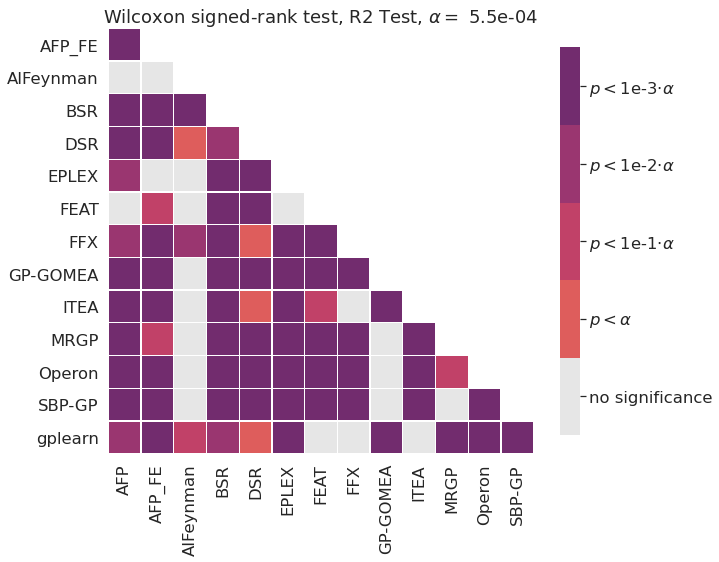

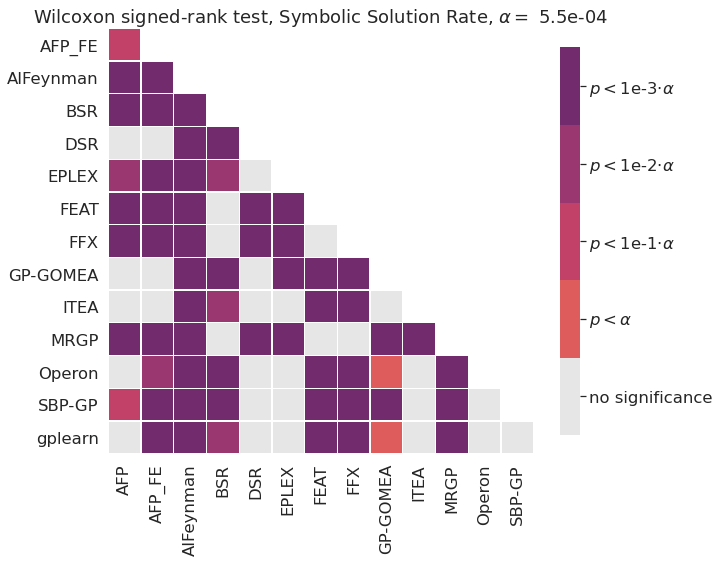

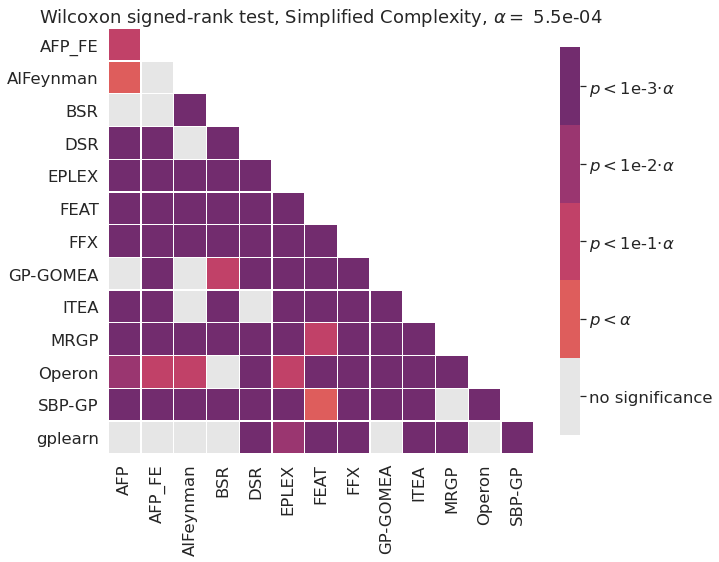

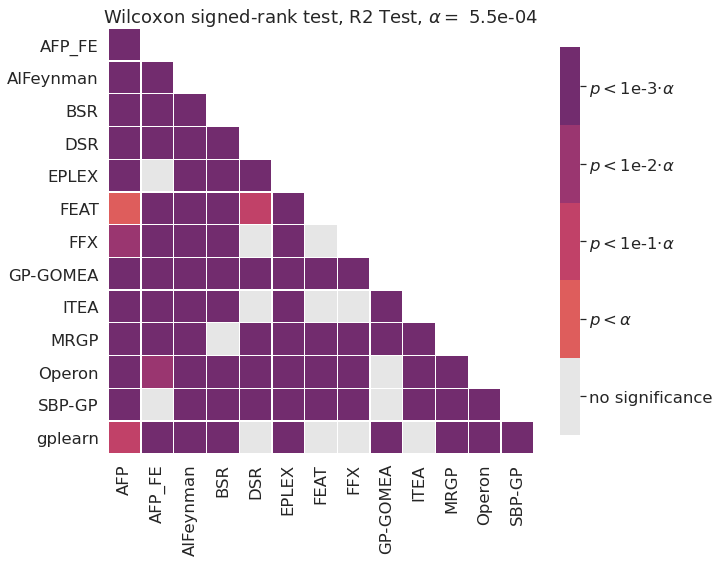

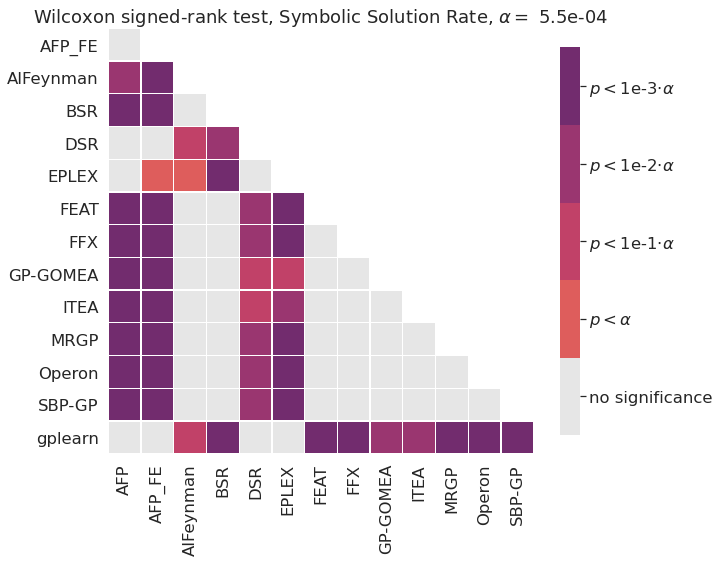

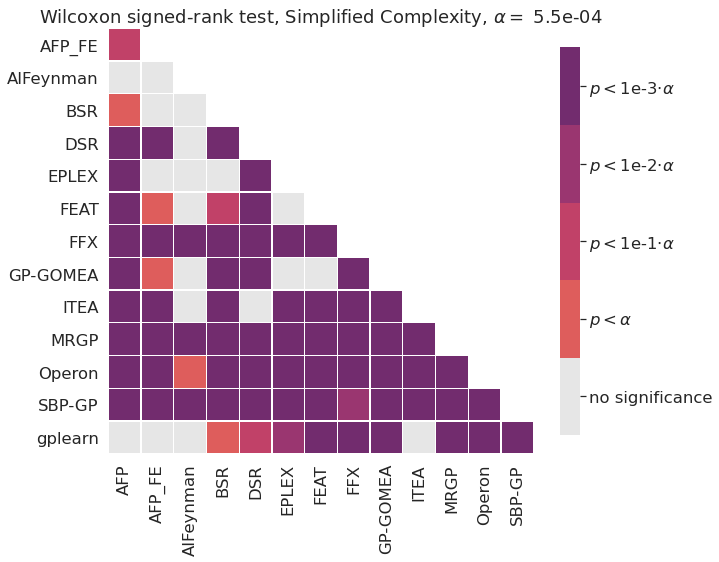

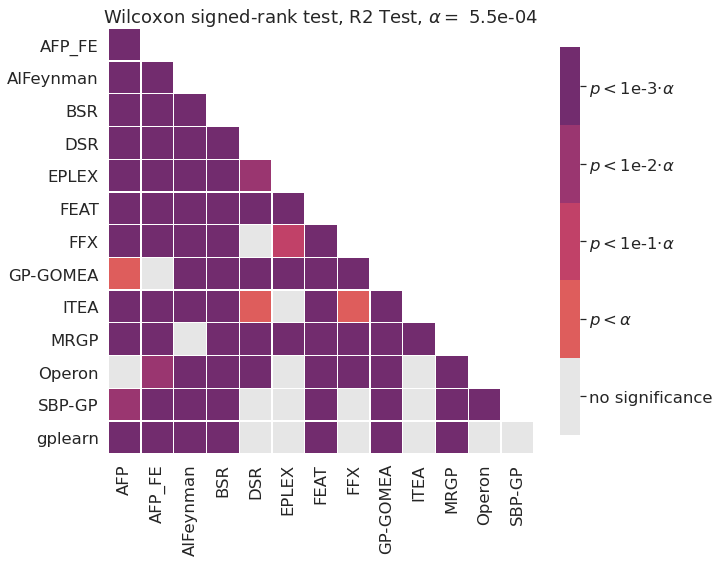

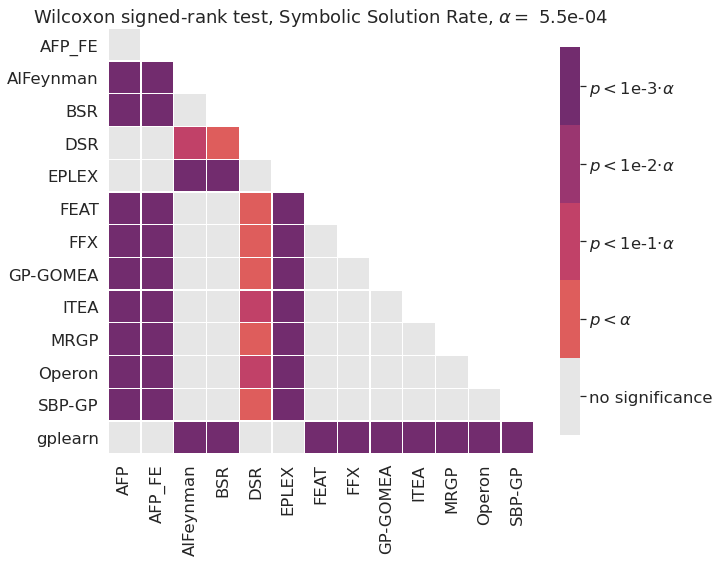

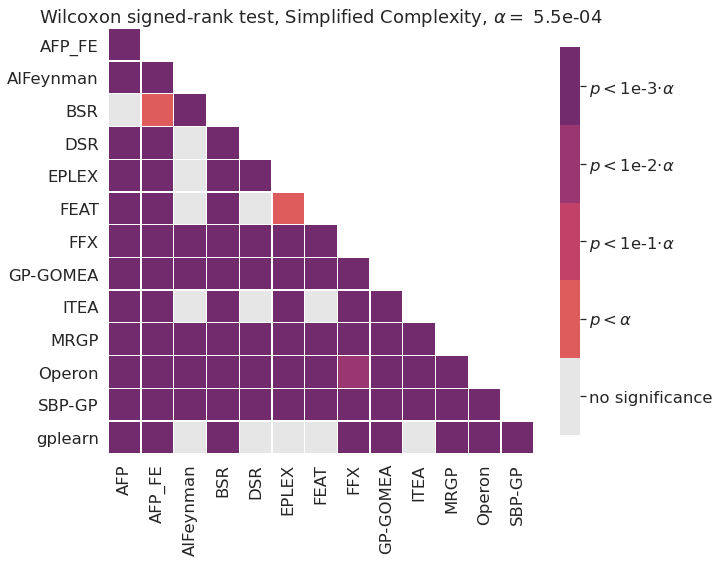

In [7]:
for target_noise, dfg in df_sum_filled.groupby('target_noise'):
    for metric in ['r2_test','symbolic_solution_rate','simplified_complexity']:
        name = 'symbolic problems target_noise='+str(target_noise)
        pval_heatmap(dfg, metric, name, algs)
    

# Black-Box datasets

## load data and fill nan results

In [8]:
df_sum = pd.read_csv(rdir+'/results_black-box_summary.csv.gz')
algs = df_sum.algorithm.unique()
datasets = df_sum.dataset.unique()

In [9]:
# if a result is missing, assign it the worst ranking
# cols = df_sum.columns
filler_frame = {
    'r2_test_rank' : len(algs)+1,
    'model_size_rank' : len(algs)+1,
}
fill_frames = []
j = 0
for dataset in datasets:
    for alg in algs:
        df = df_sum.loc[df_sum.dataset == dataset]
        if alg not in df.algorithm.unique():
            print('filling',alg,'missing for',dataset)
#                 for col in cols:
            new_fill = filler_frame.copy()
            new_fill.update({
                             'algorithm':alg,
                             'dataset':dataset,
                            })
            print(new_fill)
            fill_frames.append(new_fill)
            j += 1
            
df_fill = pd.DataFrame.from_records(fill_frames, columns=fill_frames[0].keys()) 
df_sum_filled = df_sum.append(df_fill)


filling AIFeynman missing for 1191_BNG_pbc
{'r2_test_rank': 22, 'model_size_rank': 22, 'algorithm': 'AIFeynman', 'dataset': '1191_BNG_pbc'}
filling AIFeynman missing for 197_cpu_act
{'r2_test_rank': 22, 'model_size_rank': 22, 'algorithm': 'AIFeynman', 'dataset': '197_cpu_act'}
filling AIFeynman missing for 201_pol
{'r2_test_rank': 22, 'model_size_rank': 22, 'algorithm': 'AIFeynman', 'dataset': '201_pol'}
filling AIFeynman missing for 294_satellite_image
{'r2_test_rank': 22, 'model_size_rank': 22, 'algorithm': 'AIFeynman', 'dataset': '294_satellite_image'}
filling AIFeynman missing for 4544_GeographicalOriginalofMusic
{'r2_test_rank': 22, 'model_size_rank': 22, 'algorithm': 'AIFeynman', 'dataset': '4544_GeographicalOriginalofMusic'}
filling AIFeynman missing for 505_tecator
{'r2_test_rank': 22, 'model_size_rank': 22, 'algorithm': 'AIFeynman', 'dataset': '505_tecator'}
filling AIFeynman missing for 573_cpu_act
{'r2_test_rank': 22, 'model_size_rank': 22, 'algorithm': 'AIFeynman', 'dataset

## generate tables

In [10]:
# baseline significance threshold; adjusted for no. of comparisons below
alpha = 0.05
BB_pvals = {}

for metric in ['r2_test','model_size']:
    pvals = []

    n = 0 
    df_pvals, c_alpha = get_pval_df(df_sum_filled, metric, algs) 
    pval_tbl = df_pvals.set_index(['alg1','alg2'])['pval'].unstack() 
    BB_pvals[metric] = pval_tbl.copy() 
    pval_tbl = pval_tbl.fillna('-')
    display(pval_tbl)
   
    pval_tbl

n: 210 c_alpha: 0.0002380952380952381


alg2,AFP_FE,AIFeynman,AdaBoost,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,KernelRidge,LGBM,Linear,MLP,MRGP,Operon,RandomForest,SBP-GP,XGB,gplearn
alg1,,,,,,,,,,,,,,,,,,,,
AFP,0.473574,8.61334e-19,7.15608e-08,3.48364e-21,3.45526e-13,2.59935e-13,2.1128e-15,0.0820921,1.68403e-15,0.199182,0.773778,0.0236697,4.30546e-11,0.0068415,0.00104998,4.84706e-12,6.7618e-05,1.45709e-15,8.04593e-17,5.399574e-12
AFP_FE,-,5.19655e-19,9.90584e-08,5.532e-21,2.53139e-14,5.30338e-12,1.26115e-14,0.0990965,3.54077e-14,0.402727,0.956192,0.0319594,6.12249e-12,0.0024334,0.000400209,8.14975e-12,0.000196164,1.57122e-14,1.0454e-15,4.847601e-14
AIFeynman,-,-,1.11998e-19,1.33043e-13,4.60673e-18,9.95909e-20,4.05885e-20,5.19418e-15,5.79111e-20,9.22555e-19,5.69793e-19,2.19048e-18,1.0198e-16,9.00013e-18,2.65397e-17,5.14493e-20,1.28916e-19,3.35599e-20,2.18451e-20,2.378377e-17
AdaBoost,-,-,-,3.39965e-21,1.90909e-17,8.52768e-09,1.10237e-11,0.00689425,2.16288e-09,0.0444837,0.117598,0.0526273,7.32778e-15,0.000101312,5.54248e-07,2.79814e-10,0.767916,5.03878e-13,1.3692e-15,1.397865e-15
BSR,-,-,-,-,1.78842e-19,4.33809e-21,3.31766e-21,6.0702e-05,5.9498e-21,1.63124e-18,1.15425e-21,5.23177e-13,5.33307e-17,1.6e-20,4.59705e-06,2.05698e-19,1.48882e-20,2.41409e-21,2.53528e-21,1.565685e-17
DSR,-,-,-,-,-,1.78712e-17,1.15931e-18,0.762067,7.87552e-18,5.86262e-06,0.01189,0.000734337,2.53219e-05,0.2838,0.69303,2.33851e-14,5.43189e-13,1.17459e-17,1.45593e-18,4.441397e-01
EPLEX,-,-,-,-,-,-,3.13777e-06,7.25847e-08,0.00761471,6.19759e-09,0.00131399,0.000396352,1.05295e-14,3.77748e-06,7.03818e-15,8.07297e-10,2.01295e-07,2.15134e-11,0.152122,1.980574e-16
FEAT,-,-,-,-,-,-,-,4.42284e-09,3.53969e-08,1.34668e-09,3.82431e-06,1.29253e-07,1.06732e-15,3.69714e-08,7.03254e-16,4.91729e-07,9.32844e-10,0.000301462,0.0227397,1.200820e-17
FFX,-,-,-,-,-,-,-,-,1.10979e-06,0.00997448,0.0400784,0.00982794,0.0667713,0.734959,0.648342,2.77266e-17,0.00516683,3.43953e-16,2.72264e-08,5.304942e-01


n: 210 c_alpha: 0.0002380952380952381


alg2,AFP_FE,AIFeynman,AdaBoost,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,KernelRidge,LGBM,Linear,MLP,MRGP,Operon,RandomForest,SBP-GP,XGB,gplearn
alg1,,,,,,,,,,,,,,,,,,,,
AFP,0.177281,1.37092e-17,9.2361e-22,3.00609e-10,2.58458e-21,1.74599e-21,1.00428e-17,9.23995e-22,2.21033e-07,9.23086e-22,9.2326e-22,1.33822e-21,5.54088e-13,9.234e-22,9.23995e-22,1.505e-20,9.2396e-22,9.23645e-22,9.23995e-22,3.693180e-20
AFP_FE,-,1.86736e-17,9.2375e-22,7.49554e-11,2.52562e-21,4.24989e-21,3.31036e-17,9.47075e-22,1.62158e-07,1.15338e-21,1.09807e-21,1.33817e-21,2.17529e-14,9.2361e-22,9.23995e-22,3.68504e-20,9.23995e-22,9.2389e-22,9.23995e-22,3.950480e-20
AIFeynman,-,-,3.43968e-18,8.69698e-18,1.55048e-19,2.3253e-17,4.73193e-17,0.0260542,1.22755e-17,3.90413e-16,0.000653377,6.07857e-13,9.69237e-19,8.78543e-09,1.71007e-17,4.01737e-17,1.37156e-21,2.98556e-06,1.35984e-18,1.746811e-18
AdaBoost,-,-,-,9.23575e-22,9.2319e-22,9.2354e-22,9.2382e-22,8.24955e-20,9.23715e-22,9.23785e-22,1.99631e-16,6.13379e-10,9.22981e-22,7.2997e-14,0.239365,9.22806e-22,1.14633e-19,1.09841e-21,0.0637891,9.237152e-22
BSR,-,-,-,-,2.31744e-21,2.48734e-21,6.24256e-19,9.2396e-22,7.99639e-08,1.15272e-21,2.15577e-21,1.33832e-21,0.00960534,9.22282e-22,9.23995e-22,3.71561e-21,9.2389e-22,9.23925e-22,9.23995e-22,7.783701e-02
DSR,-,-,-,-,-,9.07648e-22,1.6283e-21,9.2396e-22,9.35206e-22,9.22981e-22,9.20676e-22,1.33756e-21,0.00595599,9.19351e-22,9.23995e-22,9.11545e-22,9.23785e-22,9.23715e-22,9.2389e-22,3.148710e-13
EPLEX,-,-,-,-,-,-,4.10241e-07,1.01995e-21,9.1949e-22,1.50709e-20,4.70532e-21,1.33817e-21,8.97177e-19,9.22596e-22,9.23995e-22,6.67358e-05,9.2389e-22,9.2382e-22,9.2396e-22,9.127201e-22
FEAT,-,-,-,-,-,-,-,1.04556e-21,6.22494e-18,2.84104e-11,4.40901e-20,1.33822e-21,2.44661e-20,9.23925e-22,9.47147e-22,0.00755415,9.2396e-22,9.2389e-22,9.2396e-22,2.663786e-21
FFX,-,-,-,-,-,-,-,-,9.23995e-22,1.44107e-21,0.00351057,1.04375e-19,9.2389e-22,3.76108e-19,1.3853e-20,9.95074e-22,1.02003e-21,3.30277e-17,2.93595e-21,9.238902e-22


n: 210 c_alpha: 0.0002380952380952381
saving figs/stats//Pairwise_comparison_of_R2_Test_on_black-box_problems.png
n: 210 c_alpha: 0.0002380952380952381
saving figs/stats//Pairwise_comparison_of_Model_Size_on_black-box_problems.png


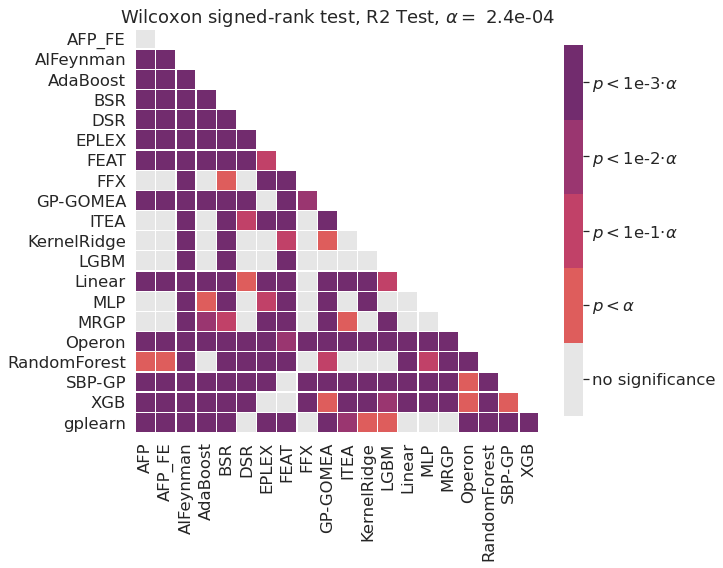

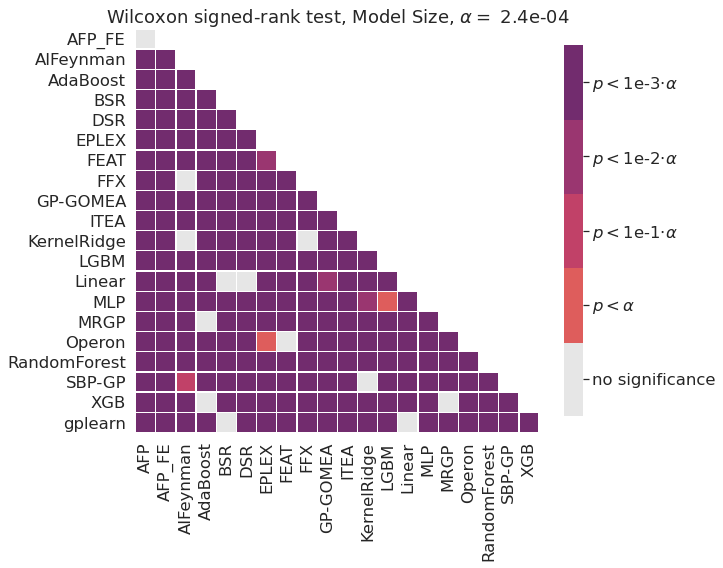

In [11]:
for metric in ['r2_test','model_size']:
    name = 'black-box problems'
    pval_heatmap(df_sum_filled, metric, name, algs)

## specific p-values referenced in manuscript

In [12]:
# first fill the matrices so we can look at either pair
for k,v in BB_pvals.items():
    algs = v.columns
    for alg1, alg2 in it.combinations(algs,2):
        if np.isnan(BB_pvals[k].loc[alg1,alg2]): 
            BB_pvals[k].loc[alg1,alg2] = BB_pvals[k].loc[alg2,alg1] 
        else:
            BB_pvals[k].loc[alg2,alg1] = BB_pvals[k].loc[alg1,alg2] 

Operon performance on BB problems

In [13]:
BB_pvals['r2_test']['Operon'].max() 

6.476527013495001e-05

FEAT model size vs SGP

In [14]:
BB_pvals['model_size'].loc['FEAT','SBP-GP']

9.23890220222e-22

Operon, SBP significantly outperform LGBM

In [15]:
BB_pvals['r2_test'].loc['XGB',['Operon','SBP-GP']].max() #.replace('-','0').astype(float).max() #.round(2)

0.00012488888017301902

Operon, SBP, and FEAT significantly outperform LGBM

In [16]:
BB_pvals['r2_test'].loc['LGBM',['Operon','FEAT','SBP-GP']].max() #.replace('-','0').astype(float).max() #.round(2)

1.2925291454848433e-07

GP models smaller than ensemble tree methods

In [17]:
import itertools as it
import numpy as np

gps = ['Operon','FEAT','EPLEX','ITEA','GP-GOMEA']
trees = ['LGBM','XGB','RandomForest','AdaBoost']
BB_pvals['model_size'].loc[gps,trees].max().max()


1.3384168364165253e-21

In [18]:
BB_pvals['r2_test'].loc[['DSR','BSR','FFX','AIFeynman'],['DSR','BSR','FFX','AIFeynman']]

alg2,DSR,BSR,FFX,AIFeynman
alg1,,,,
DSR,NaN,1.788424e-19,7.620675e-01,4.606728e-18
BSR,1.788424e-19,NaN,6.070200e-05,1.330426e-13
FFX,7.620675e-01,6.070200e-05,NaN,5.194182e-15
AIFeynman,4.606728e-18,1.330426e-13,5.194182e-15,NaN


In [19]:
BB_pvals['r2_test'].loc[['DSR','FFX'],['BSR','AIFeynman']]

alg2,BSR,AIFeynman
alg1,,
DSR,1.788424e-19,4.606728e-18
FFX,6.070200e-05,5.194182e-15


In [20]:
BB_pvals['r2_test'][['BSR','AIFeynman']]

alg2,BSR,AIFeynman
alg1,,
AFP,3.483640e-21,8.613339e-19
AFP_FE,5.532002e-21,5.196554e-19
AIFeynman,1.330426e-13,NaN
AdaBoost,3.399650e-21,1.119979e-19
BSR,NaN,1.330426e-13
DSR,1.788424e-19,4.606728e-18
EPLEX,4.338090e-21,9.959092e-20
FEAT,3.317664e-21,4.058853e-20
FFX,6.070200e-05,5.194182e-15
